In [10]:
from pathlib import Path
from itertools import product
import pandas as pd

In [11]:
methods = ['maml', 'protonet', 'matchingnet', 'baseline', 'baseline_pp']
datasets = ['tabula_muris', 'swissprot']
n_shots = [1, 5, 10]
n_ways = [5, 20]

results = []

In [12]:
# Write a function to extract the train, test and val accuracies from the log file
""" E.g. Time: 20231210-124517, Setting: swissprot-train-FCNet-protonet 5shot 5way, Acc: 89.03% +- 0.68%, Model: checkpoints/protonet_swissprot_5_5/swissprot/protonet_FCNet/20231210_124157/best_model.tar 
Time: 20231210-124602, Setting: swissprot-val-FCNet-protonet 5shot 5way, Acc: 70.02% +- 0.82%, Model: checkpoints/protonet_swissprot_5_5/swissprot/protonet_FCNet/20231210_124157/best_model.tar 
Time: 20231210-124640, Setting: swissprot-test-FCNet-protonet 5shot 5way, Acc: 62.69% +- 0.60%, Model: checkpoints/protonet_swissprot_5_5/swissprot/protonet_FCNet/20231210_124157/best_model.tar """

def extract_accs(results_file):
    with open(results_file, 'r') as f:
        lines = f.readlines()
    train, train_unc = extract_accs_from_line(lines[0])
    val, val_unc = extract_accs_from_line(lines[1])
    test, test_unc = extract_accs_from_line(lines[2])
    return train, train_unc, val, val_unc, test, test_unc

def extract_accs_from_line(line):
    acc = float(line.split(' ')[-6].split('%')[0])
    acc_unc = float(line.split(' ')[-4].split('%')[0])
    return acc, acc_unc

assert extract_accs('../../checkpoints/protonet_swissprot_5_5/results.txt') == (89.03, 0.68, 70.02, 0.82, 62.69, 0.6)


In [13]:
root = Path('../../checkpoints/')
for method, dataset, n_shot, n_way in product(methods, datasets, n_shots, n_ways):
    path = root.joinpath(f'{method}_{dataset}_{n_shot}_{n_way}')
    try:
        train, train_unc, val, val_unc, test, test_unc = extract_accs(path.joinpath('results.txt'))
        results.append({
            'method': method, 
            'dataset': dataset, 
            'n_shots': n_shot, 
            'n_ways': n_way, 
            'train': train, 
            'train_unc': train_unc, 
            'val': val, 
            'val_unc': val_unc, 
            'test': test, 
            'test_unc': test_unc
        })
    except:
        results.append({
            'method': method, 
            'dataset': dataset, 
            'n_shots': n_shot, 
            'n_ways': n_way, 
        })

In [14]:
df = pd.DataFrame(results)
df.to_csv('baselines.csv')
df.to_csv('../../../report/tables/baselines.csv')
df

,method,dataset,n_shots,n_ways,train,train_unc,val,val_unc,test,test_unc
0,maml,tabula_muris,1,5,89.69,0.82,73.64,1.10,68.63,1.11
1,maml,tabula_muris,1,20,8.67,0.18,7.67,0.21,7.14,0.18
2,maml,tabula_muris,5,5,95.34,0.48,85.49,0.75,86.19,0.66
3,maml,tabula_muris,5,20,7.93,0.22,8.28,0.20,7.60,0.19
4,maml,tabula_muris,10,5,96.59,0.35,88.54,0.67,88.93,0.63
5,maml,tabula_muris,10,20,9.27,0.29,6.58,0.21,6.79,0.24
6,maml,swissprot,1,5,92.25,0.68,48.47,1.01,49.05,1.08
7,maml,swissprot,1,20,NaN,NaN,NaN,NaN,NaN,NaN
8,maml,swissprot,5,5,94.83,0.50,53.15,0.91,43.50,0.64
9,maml,swissprot,5,20,NaN,NaN,NaN,NaN,NaN,NaN


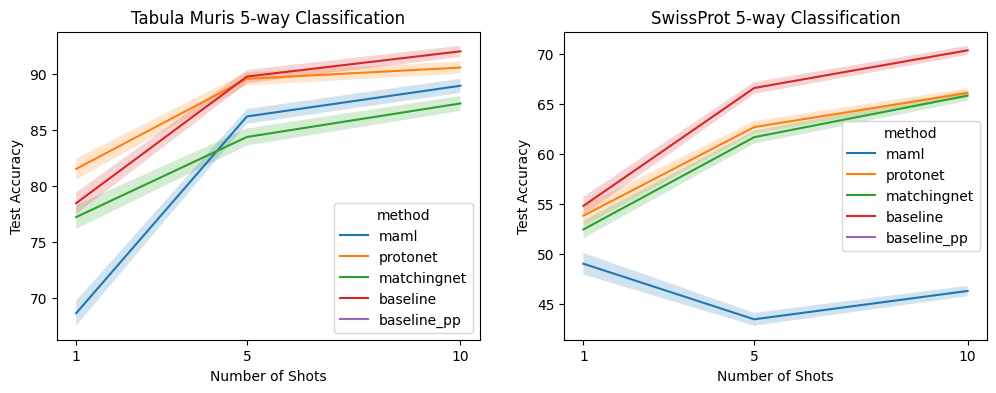

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

tabula_5way = df[(df['dataset'] == 'tabula_muris') & (df['n_ways'] == 5)]
swissprot_5way = df[(df['dataset'] == 'swissprot') & (df['n_ways'] == 5)]

axs[0] = sns.lineplot(x='n_shots', y='test', hue='method', data=tabula_5way, errorbar=None, ax=axs[0])
axs[0].set_ylabel('Test Accuracy')
axs[0].set_xlabel('Number of Shots')
axs[0].set_title('Tabula Muris 5-way Classification')
axs[0].set_xticks([1,5,10])

axs[1] = sns.lineplot(x='n_shots', y='test', hue='method', data=swissprot_5way, errorbar=None, ax=axs[1])
axs[1].set_ylabel('Test Accuracy')
axs[1].set_xlabel('Number of Shots')
axs[1].set_title('SwissProt 5-way Classification')
axs[1].set_xticks([1,5,10])

for method in methods:
    method_df = tabula_5way[tabula_5way['method'] == method]
    axs[0].fill_between([1,5,10], method_df['test'] - method_df['test_unc'], method_df['test'] + method_df['test_unc'], alpha=0.2)
    method_df = swissprot_5way[swissprot_5way['method'] == method]
    axs[1].fill_between([1,5,10], method_df['test'] - method_df['test_unc'], method_df['test'] + method_df['test_unc'], alpha=0.2)

plt.savefig('../../../report/figures/nshot.png', bbox_inches='tight')
plt.show()